## Perform bootstrapping ROC AUC method to determine if QC significantly improves performance of model

In this method, we have trained two models; one with QC'd data and the other without QC'd data (more noise). 
To assess quality, apply the models to a holdout dataset that both models have never seen that has been QC'd.
We take subsamples of this dataset to perform a bootstapping method that will calculate the ROC AUC across the QC'd holdout samples.

The goal of this analysis is to see how well the models perform when applied to a new dataset that has only "good" cells, since we will be applying QC to all future plates.


## Import libraries

In [1]:
import pathlib
import joblib
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import matplotlib.colors as mcolors
from scipy.stats import ttest_ind

import sys

sys.path.append("../../utils")
from training_utils import get_X_y_data

## Define function

In [2]:
# Define function to preform bootstrapping
def bootstrap_roc_auc(y_true, y_pred, n_bootstraps=1000):
    """
    Perform bootstrapping to compute the distribution of ROC AUC scores.

    This function generates a bootstrapped distribution of ROC AUC scores by 
    resampling the provided true labels and predicted probabilities with 
    replacement.

    Parameters:
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels (0 or 1) for the dataset.
        
    y_pred : array-like of shape (n_samples,)
        Predicted probabilities or scores for the positive class.
        
    n_bootstraps : int, optional, default=1000
        Number of bootstrap iterations to perform.

    Returns:
    -------
    bootstrapped_scores : np.ndarray
        An array of bootstrapped ROC AUC scores. Each element represents the 
        ROC AUC computed for a resampled dataset.
    """

    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    return np.array(bootstrapped_scores)

## Load in non-QC model and dataset

In [3]:
# Load the no_QC trained model
no_QC_model = joblib.load(
    pathlib.Path(
        "../0.train_logistic_regression/models/no_QC_models/log_reg_fs_plate_4_final_downsample_no_QC.joblib"
    )
)

# Load the feature-selected data (ensure it includes both features and labels)
no_QC_plate_4_data = pd.read_parquet(
    pathlib.Path(
        "../../3.process_cfret_features/data/single_cell_profiles/localhost231120090001_sc_feature_selected_no_QC.parquet"
    ).resolve(strict=True)
)

# Load the normalized QC'd data that we will filter and apply the model to
plate_4_QC_data = pd.read_parquet(
    pathlib.Path(
        "../../3.process_cfret_features/data/single_cell_profiles/localhost231120090001_sc_normalized.parquet"
    )
)

# Filter out columns feature columns
no_QC_model_columns = [
    col for col in no_QC_plate_4_data.columns if not col.startswith("Metadata")
]

len(no_QC_model_columns)

648

### Filter the QC'd data with the features used in the non-QC'd model

In [4]:
# Get metadata columns from the plate 4 QC'd data
metadata_columns = [
    col for col in plate_4_QC_data.columns if col.startswith("Metadata")
]

# Filter out the columns that aren't in the no QC model
common_filtered_columns = [
    col for col in plate_4_QC_data.columns if col in no_QC_model_columns
]

# Combine the common feature columns with metadata columns to filter out the main dataframe
all_filtered_columns = common_filtered_columns + metadata_columns

# Filter the plate_4 normalized data with the model features
plate_4_data_filtered = plate_4_QC_data[all_filtered_columns]

# Filter the plate 4 QC'd data to only include rows where:
# - Metadata_heart_number == 7 and Metadata_treatment == "DMSO"
# - OR Metadata_heart_number == 29
holdout_data_no_QC_model = plate_4_data_filtered[
    ((plate_4_data_filtered["Metadata_heart_number"] == 7) & (plate_4_data_filtered["Metadata_treatment"] == "DMSO")) |
    (plate_4_data_filtered["Metadata_heart_number"] == 29)
]

# Load in X and y data from QC'd data with the features for the no QC model
X, y = get_X_y_data(df=holdout_data_no_QC_model, label="Metadata_cell_type")

### Apply no QC model to the QC'd data to extract probabilites

In [5]:
# load in label encoder
le = load(
    pathlib.Path(
        "../0.train_logistic_regression/encoder_results/label_encoder_log_reg_fs_plate_4.joblib"
    )
)

# Assign y classes to correct binary using label encoder results
y_binary = le.transform(y)

# Predict probabilities for the positive class
y_probs_modelNoQC = no_QC_model.predict_proba(X)[:, 1]

## Load in QC model and QC data

### Extract probabilities from the QC'd data using the QC model

In [6]:
# Load the trained model
QC_model = joblib.load(
    pathlib.Path(
        "../0.train_logistic_regression/models/log_reg_fs_plate_4_final_downsample.joblib"
    )
)

# Load the feature-selected QC plate 4 (ensure it includes both features and labels)
plate_4_QC = pd.read_parquet(
    pathlib.Path(
        "../../3.process_cfret_features/data/single_cell_profiles/localhost231120090001_sc_feature_selected.parquet"
    )
)

# Filter the test_data to only include rows where:
# - Metadata_heart_number == 7 and Metadata_treatment == "DMSO"
# - OR Metadata_heart_number == 29
holdout_QC_data = plate_4_QC[
    (
        (plate_4_QC["Metadata_heart_number"] == 7)
        & (plate_4_QC["Metadata_treatment"] == "DMSO")
    )
    | (plate_4_QC["Metadata_heart_number"] == 29)
]

# Load in X and y data from dataset
X, y = get_X_y_data(df=holdout_QC_data, label="Metadata_cell_type")

# Assign y classes to correct binary using label encoder results
y_binary = le.transform(y)

# Predict probabilities for the positive class
y_probs_modelQC = QC_model.predict_proba(X)[:, 1]

## Calculate the ROC AUC score from applying the QC'd holdout data to both models

In [7]:
# Calculate ROC AUC
aucNoQC = roc_auc_score(y_binary, y_probs_modelNoQC)
aucQC = roc_auc_score(y_binary, y_probs_modelQC)

print(f"AUC Model 1: {aucNoQC}")
print(f"AUC Model 2: {aucQC}")

AUC Model 1: 0.9115288263122489
AUC Model 2: 0.9288569897636957


## Apply bootstrap ROC function and perform a t-test to determine significant difference between distributions

In [8]:
# No QC model
scores_model1 = bootstrap_roc_auc(y_binary, y_probs_modelNoQC)

# QC model
scores_model2 = bootstrap_roc_auc(y_binary, y_probs_modelQC)

# Compare distributions
t_stat, p_value = ttest_ind(scores_model1, scores_model2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -72.09813518227527, P-value: 0.0


In [9]:
print(f"Mean ROC AUC for Model No-QC: {np.mean(scores_model1)}")
print(f"Mean ROC AUC for Model QC: {np.mean(scores_model2)}")

Mean ROC AUC for Model No-QC: 0.9116075137342311
Mean ROC AUC for Model QC: 0.9287014253247733


## Create histogram plot with the AUC ROC bootstrap distributions

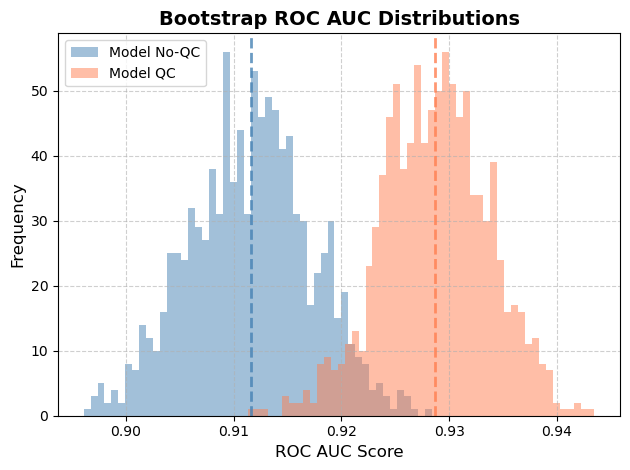

In [10]:
# Define darker colors for the mean lines
darker_steelblue = mcolors.to_rgba("steelblue", 0.8)
darker_coral = mcolors.to_rgba("coral", 0.8)

plt.hist(scores_model1, bins=50, alpha=0.5, label="Model No-QC", color="steelblue")
plt.hist(scores_model2, bins=50, alpha=0.5, label="Model QC", color="coral")

# Add vertical lines for the means
plt.axvline(
    np.mean(scores_model1),
    color=darker_steelblue,
    linestyle="dashed",
    linewidth=2,
)
plt.axvline(
    np.mean(scores_model2),
    color=darker_coral,
    linestyle="dashed",
    linewidth=2,
)

plt.legend(loc="upper left", fontsize=10)
plt.xlabel("ROC AUC Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Bootstrap ROC AUC Distributions", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# save figure
plt.savefig("./figures/bootstrap_plot.png", dpi=600)

plt.show()